In [ ]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
import cv2
from tqdm import tqdm
from skimage.color import rgb2gray
from scipy import ndimage
%matplotlib inline

import pandas as pd
import numpy as np
import pickle
from PIL import Image
import random
from skimage.feature import hog


from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import svm

from sklearn.metrics import roc_curve, auc

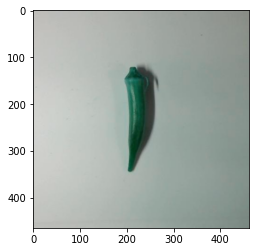

In [ ]:
DATADIR = "/content/drive/My Drive/okra_image"

CATEGORIES = ["August_RGB_A", "August_RGB_B"]

for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  # create path 
    for img in os.listdir(path):  # iterate over each image 
        image = cv2.imread(os.path.join(path,img) )  # convert to array
        image.shape 
        plt.imshow(image)

        break  
    break  

In [ ]:
IMG_LONG = 128
IMG_LARGE = 128

In [ ]:
training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  

        for img in tqdm(os.listdir(path)):   
            try:
                image = cv2.imread(os.path.join(path,img))                
                new_array = image
                new_array = cv2.resize(new_array,(IMG_LONG, IMG_LARGE))
                training_data.append([new_array, class_num])
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
            
            
create_training_data()
print("")
print(len(training_data))

100%|██████████| 506/506 [04:17<00:00,  1.97it/s]


758


In [ ]:
random.shuffle(training_data)
for sample in training_data[:7]:
    print(sample[1])

0
0
1
0
1
1
1


In [ ]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42,
)

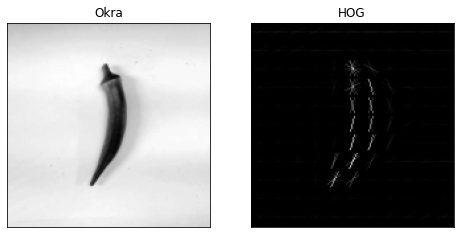

In [ ]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
dog = imread('/content/drive/My Drive/okra_image/August_RGB_A/08_02_A_not_B_org_20190719_081125.jpeg', as_gray=True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# scale down the image to one third
dog = rescale(dog, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(
    dog, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(dog, cmap='gray')
ax[0].set_title('Okra')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('HOG')
plt.show()

In [ ]:
print('number of pixels: ', dog.shape[0] * dog.shape[1])
print('number of hog features: ', dog_hog.shape[0])

number of pixels:  23870
number of hog features:  3600


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
 
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8, 8),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(606, 8100)


In [ ]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [ ]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:35])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True]

Percentage correct:  98.6842105263158


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(8, 8),
        cells_per_block=(2,2),
        orientations=9,
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct:  98.6842105263158


In [ ]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {'hogify__orientations': [9],
    'hogify__cells_per_block': [(3, 3)],
    'hogify__pixels_per_cell': [(8, 8), (14, 14)]},
    {'hogify__orientations': [9],
     'hogify__cells_per_block': [(3, 3)],
     'hogify__pixels_per_cell': [(14, 14)],
     'classify': [
         SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
         svm.SVC(kernel='linear')]}
]

In [ ]:
grid_search = GridSearchCV(HOG_pipeline,
                           param_grid,
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   52.0s finished


In [ ]:

# The best performing pipeline
grid_res.best_estimator_

Pipeline(memory=None,
         steps=[('grayify', RGB2GrayTransformer()),
                ('hogify',
                 HogTransformer(block_norm='L2-Hys', cells_per_block=(3, 3),
                                orientations=9, pixels_per_cell=(14, 14),
                                y=None)),
                ('scalify',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classify',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:

# the highscore during the search
grid_res.best_score_

0.9851485148514851

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  99.34210526315789
